In [1]:
'''
    CMSC 678 Machine Learning
    Assignment 4
    Dimension Reduction using SVD
    Author - Oyesh Mann Singh
    Date - 12/06/2017
'''

import numpy as np

from sklearn import svm
from sklearn.neural_network import MLPClassifier

import pandas as pd
from pandas import Series, DataFrame as df

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# For Binary or Multi-Class
classes = [1,6]
all_classes = [0,1,2,3,4,5,6,7,8,9]

# Number of images to be selected from each_class
each_class=100

# Dataset Loader
class MnistDataset(object):
    def __init__(self, csv_file, classes=classes, each_class=0, sort=False, rand=False):
        df = pd.read_csv(csv_file)
        
#         # To randomly sample data training/testing dataset
#         if rand:
#             raw_data = df.sample(each_class * len(classes))
#         else:
#             raw_data = df.loc[df['label'].isin(classes)]
        
#         if each_class > 0 and sort:
#             self.data = raw_data.groupby('label').head(each_class).sort_values(['label'])
#         elif each_class > 0 and not sort:
#             self.data = raw_data.groupby('label').head(each_class)
#         else:
        self.data = df.sample(1000)
        self.label = self.data.iloc[:,0]
        self.image = self.data.iloc[:,1:]
        
    def __len__(self):
        return len(self.data)

In [2]:
# Load dataset
train_dataset = MnistDataset('./data/train.csv',classes=all_classes,each_class=each_class,rand=True)
test_dataset = MnistDataset('./data/test.csv',classes=all_classes,each_class=each_class,rand=True)

# Convert dataframe to nd-array
train_images = train_dataset.image.values
train_labels = train_dataset.label.values

test_images = test_dataset.image.values
test_labels = test_dataset.label.values

# Dimension of each image
num_of_features = len(train_images[0])

# Length of each dataset
num_of_train_data = len(train_images)
num_of_test_data = len(test_images)

# Display image
def display(X,Y):
    img = X.reshape(28,28)
    plt.title('Label : {0}'.format(Y))
    plt.imshow(img)
    
# Display eigen vector
def display_eigen(X,Y):
    img = X.reshape(28,28)
    plt.title('Lambda : {0}'.format(Y))
    plt.imshow(img)

Display sample image from dataset


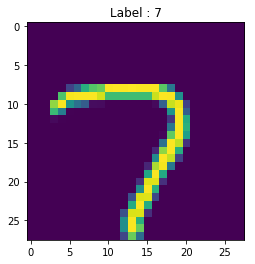

In [3]:
print('Display sample image from dataset')
display(train_images[1],train_labels[1])

In [4]:
'''
    Usage of SVM
'''
model = svm.LinearSVC()

model.fit(train_images, train_labels)

def calc_accuracy():
    pred_labels = model.predict(test_images)
    acc = np.mean(pred_labels == test_labels)
    print('SVM Accuracy')
    print('==========')
    print('Using manual calculation -> {0:.3f}%'.format(acc * 100.0))
    print('Using built-in function -> {0:.3f}%'.format(model.score(test_images,test_labels) * 100.0))

calc_accuracy()

SVM Accuracy
Using manual calculation -> 83.400%
Using built-in function -> 83.400%


In [5]:
def calc_decision_values(x):
    '''
        Manual calculation of decision values
    '''
    dec_val = np.zeros((test_images.shape[0], len(all_classes)))
    for i in range(test_images.shape[0]):
        for j in range(len(all_classes)):
            dec_val[i][j] = np.dot(model.coef_[j], test_images[i]) + model.intercept_[j]
    
    print('Decision value using manual calculation')
    print('For image index : {0} Ground Truth : {1}'.format(x, test_labels[x]))
    print(dec_val[x])
    print()
    
    
    '''
        Using built-in function for decision values
    '''    
    decision_val = model.decision_function(test_images)
    print('Decision value using built-in function')
    print('For image index : {0} Ground Truth : {1}'.format(x, test_labels[x]))
    print(decision_val[x])

calc_decision_values(0)

Decision value using manual calculation
For image index : 0 Ground Truth : 2
[ -1.33814694  -5.9174051    4.03509732  -3.9332424   -3.41996061
  -3.67772463  -4.84124491  -6.09019894 -16.84033696  -7.32453877]
()
Decision value using built-in function
For image index : 0 Ground Truth : 2
[ -1.33814694  -5.9174051    4.03509732  -3.9332424   -3.41996061
  -3.67772463  -4.84124491  -6.09019894 -16.84033696  -7.32453877]


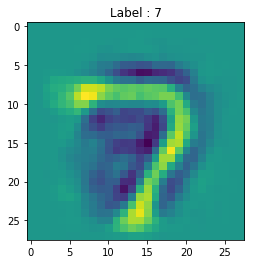

In [6]:
'''
    Mean vector
'''
# mew = np.array((train_images.shape[1],1))
# mew = train_images.sum(axis=0)/train_images.shape[0]
mu_train = np.mean(train_images, axis=0)
train_images = train_images - mu_train

mu_test = np.mean(test_images, axis=0)
test_images = test_images - mu_test

'''
    ***********************
    USE SVD 
    Dimension is reduced to 50
    by assigning zeros to remaning
    s[50:0] = 0
    ***********************

'''
U,s,V = np.linalg.svd(train_images, full_matrices=False)
reduced_s = s
reduced_s[50:] = 0
S = np.diag(reduced_s)
# Reconstruction
final_X = np.dot(U, S.dot(V))

# data to be displayed
num = 1
display(final_X[num],train_labels[num])

In [7]:
'''
    Scaling images from 0 to 1
'''
scaled_train_images = train_images/255.0
Y_pred = final_X
Y_gt = scaled_train_images

'''
    Calculation of Mean Square Error
'''
def mse(Y_pred, Y_gt):
    total_pixels = Y_pred.shape[0] * Y_pred.shape[1]
    calc_mse = np.sum((Y_pred - Y_gt) ** 2) / total_pixels
    return calc_mse

# print(mse(Y_pred, Y_gt))

'''
    List of 50 dimensions logarithmically
    from 1 to 500
'''
dim = np.logspace(0,2.698970004336,50).astype(int)
print('List of dimensions logarithmically separated from 1 to 50')
print(dim)

List of dimensions logarithmically separated from 1 to 50
[  1   1   1   1   1   1   2   2   2   3   3   4   4   5   5   6   7   8
   9  11  12  14  16  18  20  23  27  30  34  39  44  50  57  65  74  84
  96 109 123 140 159 181 205 233 265 301 341 387 440 499]


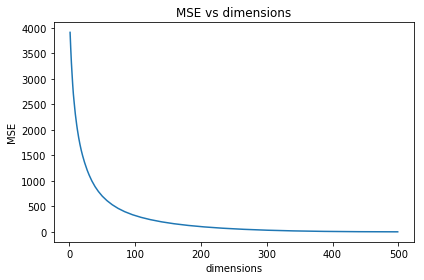

In [8]:
'''
    Calculate MSE based on dimensions
'''
def calculate_mse(X, dim):
    U,s,V = np.linalg.svd(X, full_matrices=False)
    reduced_s = s
    reduced_s[dim:] = 0
    S = np.diag(reduced_s)
    Y_pred = np.dot(U, np.dot(S, V))
    total_pixels = Y_pred.shape[0] * Y_pred.shape[1]
    calc_mse = np.sum((Y_pred - X) ** 2) / total_pixels
    
    return calc_mse

'''
    Plot MSE vs Dimensions
'''
def plot(mse_list):
    plt.rcParams.update({'font.size': 10})
    plt.plot(dim, mse_list)
    plt.title('MSE vs dimensions')
    plt.xlabel('dimensions')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.show()

'''
    Calculate MSE of each dimension
    And plot based on results
'''
def mse_plot(X,dim):
    mse_list = []
    for i in dim:
        mse_list.append(calculate_mse(X=X,dim=i))

    plot(mse_list)

mse_plot(X=train_images,dim=dim)

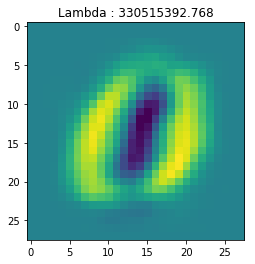

In [9]:
'''
    Display single eigen vector
'''
U,s,V = np.linalg.svd(train_images, full_matrices=False)
n = 0
display_eigen(V[n],s[n] ** 2)

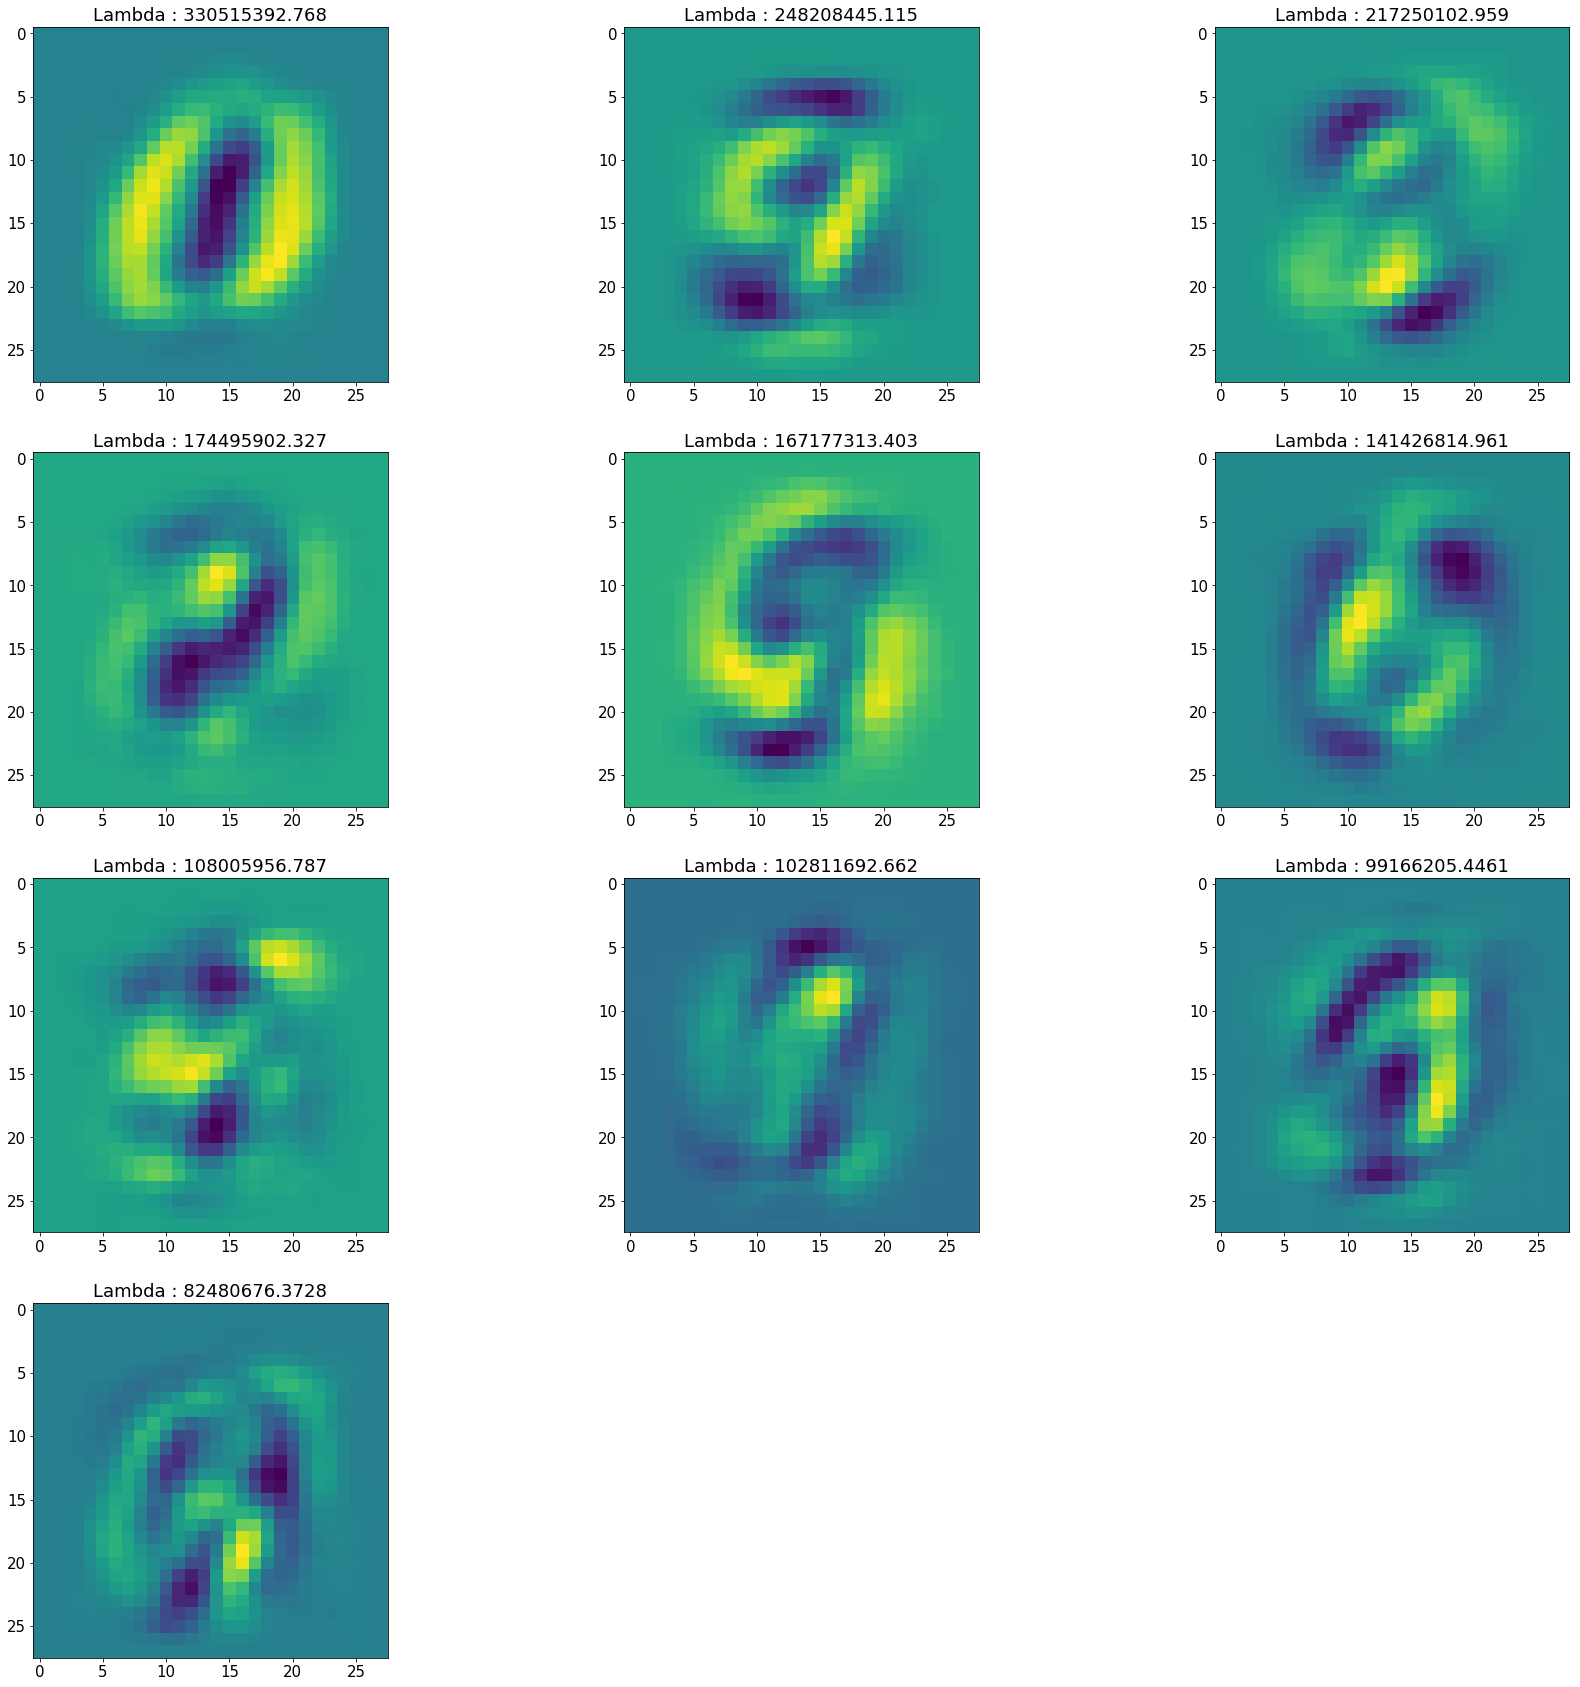

In [17]:
'''
    Visualize top eigen vectors
'''
def visualize(X=train_images):
    # Calculate U,s,V using svd
    U,s,V = np.linalg.svd(train_images, full_matrices=False)
    
    # Select top 10 eigen vectors
    topV = V[0:10]
    
    plt.rcParams.update({'font.size': 15})
    fig=plt.figure(figsize=(30,30))
#     fig.tight_layout(h_pad=2.0)
    columns = 3
    rows = 4
    for i in range(len(topV)):
        reshaped_img = topV[i].reshape(28,28)
        eig_val = s[i] ** 2
        fig.add_subplot(rows, columns, i+1)
        plt.title('Lambda : {0}'.format(eig_val))
        plt.imshow(reshaped_img)

visualize()

In [12]:
'''
    Reduces dimension of given dataset
'''
def reduce_dim(X, dim):
    U,s,V = np.linalg.svd(X, full_matrices=False)
    reduced_s = s
    reduced_s[dim:] = 0
    S = np.diag(reduced_s)
    final_X = np.dot(U, S.dot(V))
    return final_X

'''
    Prepare low dimension dataset
'''
low_dim_train_images = reduce_dim(train_images, 50)
low_dim_test_images = reduce_dim(test_images, 50)

'''
    Usage of SVM on low dimension dataset
'''
low_dim_model =  svm.LinearSVC()
low_dim_model.fit(low_dim_train_images, train_labels)

pred_labels = low_dim_model.predict(low_dim_test_images)
ld_acc = np.mean(pred_labels == test_labels)
print('SVM')
print('==========')
print('Accuracy -> {0:.3f}%'.format(ld_acc * 100.0))
# print('Using built-in function -> {0:.3f}%'.format(low_dim_model.score(low_dim_test_images,test_labels) * 100.0))

SVM
Accuracy -> 48.800%


In [ ]:
'''
    Usage of SVM on low dimension dataset
    after preparing dataset from given
    dimension list
'''
dim_list = [2,5,10,20,30,50,70,100,150,200,250,300,400,500,748]
total_svm_loss = []

for i in dim_list:
    low_dim_train_images = reduce_dim(train_images, i)
    low_dim_test_images = reduce_dim(test_images, i)
    
    low_dim_model =  svm.LinearSVC()

    low_dim_model.fit(low_dim_train_images, train_labels)
    
    pred_labels = low_dim_model.predict(low_dim_test_images)
    
    curr_acc = np.mean(pred_labels == test_labels)
    
    total_svm_loss.append(curr_acc % 100.00)

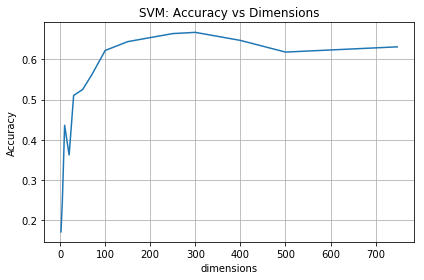

In [13]:
'''
    Plot SVM accuracy vs dimension
'''
def plot_svm_acc(x_label=dim_list, y_label=total_svm_loss):
    plt.rcParams.update({'font.size': 10})
    plt.grid(True)
    plt.plot(x_label, y_label)
    plt.title('SVM: Accuracy vs Dimensions')
    plt.xlabel('dimensions')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

plot_svm_acc(dim_list, total_svm_loss)

In [14]:
'''
    Usage of Neural Network on
    low dimension dataset
'''

nn_clf = MLPClassifier(solver='adam', alpha=1e-5, random_state=1, hidden_layer_sizes=100)
nn_clf.fit(low_dim_train_images, train_labels)

nn_pred_labels = nn_clf.predict(low_dim_test_images)
nn_acc = np.mean(nn_pred_labels == test_labels)
print('Neural Network')
print('Hidden Layer:{0} Max Iteration:{1}'.format(nn_clf.hidden_layer_sizes, nn_clf.max_iter))
print('==========')
print('Accuracy -> {0:.3f}%'.format(nn_acc * 100.0))
# print('Using built-in function -> {0:.3f}%'.format(nn_clf.score(low_dim_test_images,test_labels) * 100.0))

Neural Network
Hidden Layer:100 Max Iteration:200
Accuracy -> 83.300%


In [15]:
'''
    Usage of Neural Network on low dimension dataset
    after preparing dataset from given
    dimension list
'''
total_nn_loss = []

for i in dim_list:
    low_dim_train_images = reduce_dim(train_images, i)
    low_dim_test_images = reduce_dim(test_images, i)
    
    nn_clf = MLPClassifier(solver='adam', alpha=1e-5, random_state=1)

    nn_clf.fit(low_dim_train_images, train_labels)
    
    pred_labels = nn_clf.predict(low_dim_test_images)
    
    nn_acc = np.mean(pred_labels == test_labels)
    
    total_nn_loss.append(nn_acc % 100.00)

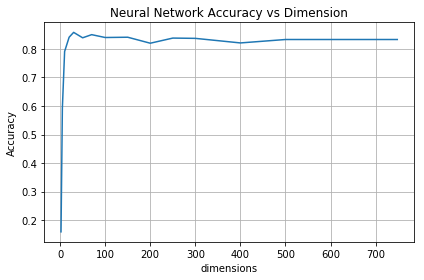

In [16]:
'''
    Plot Neural Network accuracy vs dimension
'''
def plot_nn_acc(x_label=dim_list, y_label=total_nn_loss):
    plt.rcParams.update({'font.size': 10})
    plt.grid(True)
    plt.plot(x_label, y_label)
    plt.title('Neural Network Accuracy vs Dimension')
    plt.xlabel('dimensions')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

plot_nn_acc(dim_list, total_nn_loss)